In [5]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

from sklearn.ensemble.partial_dependence import plot_partial_dependence

import matplotlib.pyplot as plt

from data_transform import *

%matplotlib inline

In [6]:
data = clean_all(file_path, NA_columns, fill_NA_dt, dummy_categories, drop_lst, cut_off_date)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,avg_rating_of_driver_isNA,avg_rating_by_driver_isNA,phone_isNA,city_Astapor,city_Winterfell,city_King's Landing,phone_Android,phone_iPhone,phone_Unspecified,isActive
0,6.94,5.0,5.0,1.00,0.0,0,False,100.0,0,0,0,1,0,0,1,0,0,False
1,8.06,5.0,5.0,1.00,0.0,2,True,0.0,0,0,0,1,0,0,1,0,0,False
2,21.50,4.0,0.0,1.00,0.0,1,True,100.0,1,0,0,0,1,0,0,1,0,False
3,9.46,5.0,0.0,2.75,100.0,1,False,100.0,1,0,0,0,1,0,1,0,0,False
4,13.77,5.0,0.0,1.00,0.0,0,False,100.0,1,0,0,0,1,0,0,1,0,False


In [41]:
#define a function that can be re-used to test different models
def get_model_error(model, X, y, test_size):
    trainX, testX, trainY, testY = train_test_split(X, y, test_size = test_size)
    model.fit(trainX, trainY)
    pred = model.predict_proba(testX)
    predX = model.predict(trainX)
    print(" train error " + str(log_loss(trainY, predX)) + " train error " + str(log_loss(testY, pred)))
    return 

In [45]:
X = data.values[:, :-1]
y = ~data['isActive']

logistic_model = LogisticRegression()
gradient_boost_model = GradientBoostingClassifier()
random_forest_model = RandomForestClassifier()

rf = get_model_error(random_forest_model, X, y, 0.2)
gb = get_model_error(gradient_boost_model, X, y, 0.2)
lr = get_model_error(logistic_model, X, y, 0.2)

print(rf, gb, lr)

 train error 0.6767497971446328 train error 1.6500651412332095
 train error 7.054642854433767 train error 0.45171886287302265
 train error 9.207964822583946 train error 0.5506616623159127
None None None


In [46]:
# gradient boosting seems to be the best one. I will continue fine-tuning its parameters

In [49]:
def stage_score_plot(estimator, X_train, y_train, X_test, y_test):
    '''
    Parameters: estimator: GradientBoostingClassifier
                X_train: 2d numpy array
                y_train: 1d numpy array
                X_test: 2d numpy array
                y_test: 1d numpy array

    Returns: A plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    estimator.fit(X_train, y_train)
    train_mse_at_stages = []
    test_mse_at_stages = []
    
    for y1, y2 in zip(estimator.staged_predict_proba(X_train), estimator.staged_predict_proba(X_test)):
        train_mse = log_loss(y_train, y1[:, 1])
        train_mse_at_stages.append(train_mse)
        
        test_mse = log_loss(y_test, y2[:,1])
        test_mse_at_stages.append(test_mse)
        
    xs = range(0, len(test_mse_at_stages))
    

    ax.plot(xs, train_mse_at_stages, 
            label="{} Train - :n estimators = {}".format(estimator.__class__.__name__, estimator.n_estimators))
    ax.plot(xs, test_mse_at_stages, 
            label="{} Test - : n estimators = {}".format(estimator.__class__.__name__, estimator.n_estimators))

## Gradient Boosting Hyperparameter Tuning
 - n_estimator should be the where the log loss for testing data is the lowest. 
 See plot in jupyter notebook 'Conclusions'. The optimal n_estimator is 550.
 - sub-sampling in default setting is 1, which is no sampling. I changed it to 0.5. an empirically adequate value. 
 The resulting log loss has been improved a little compared to the previous default setting.

Text(0,0.5,'log loss')

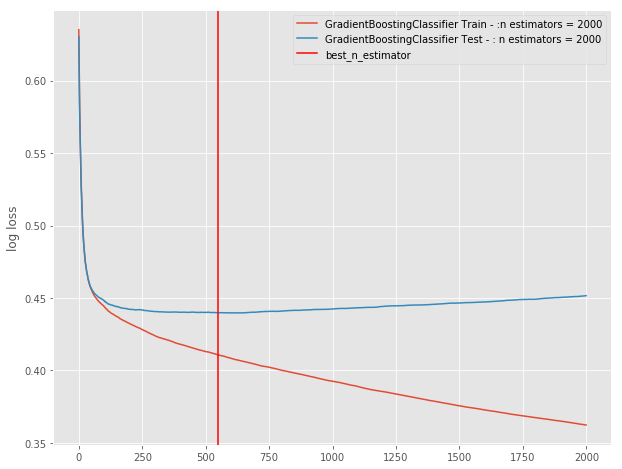

In [56]:
fig, ax = plt.subplots(figsize = (10,8))
test_size = 0.2
trainX, testX, trainY, testY = train_test_split(X, y, test_size = test_size)

gradient_boost_model = GradientBoostingClassifier(n_estimators=2000)
stage_score_plot(gradient_boost_model, X_train, y_train, X_test, y_test)
best_n_estimator = 550
ax.axvline(best_n_estimator, color='r', label='best_n_estimator')
ax.legend()
ax.set_ylabel('log loss')

In [57]:
gradient_boost_model = GradientBoostingClassifier(n_estimators=550, subsample=0.5)

gb = get_model_error(gradient_boost_model, X, y, 0.2)

 train error 6.3876047143453345 train error 0.43329291756273325


## Partial Dependence Plots
I am interested in the independent variables that contribute to the dependent variable most. Feature importance in a model can only show the feature importance relative ranking in the realm of that particular model. Partial Dependence plot will be used to better show the relationship I am looking for.

-- Interesting discoveries
- As average rating by driver increases, a customer is less likely to churn, until the rating hits 5. A possible reasoning could be that 5-star customers haven't had many trips. Maybe they are just trying it out, hence not loyal customers. Marketing material could potentially target this group to retain this group's interest

- Average surge doesn't appear to affect churn rate much

- trips in first 30 days has interesting ups and downs with an overall trend of increasing chance of churn. Attractive promotions are generally given for new customers. Some price-customers will stop using the app once promotion is used, hence the upward segments; some customers are retained in the process, hence the downward segments. A potential move to keep the price-concious segment of customers might be individualized coupon per month instead of giving all the promotions within the first month. 

note: the y-axis is in log odds units

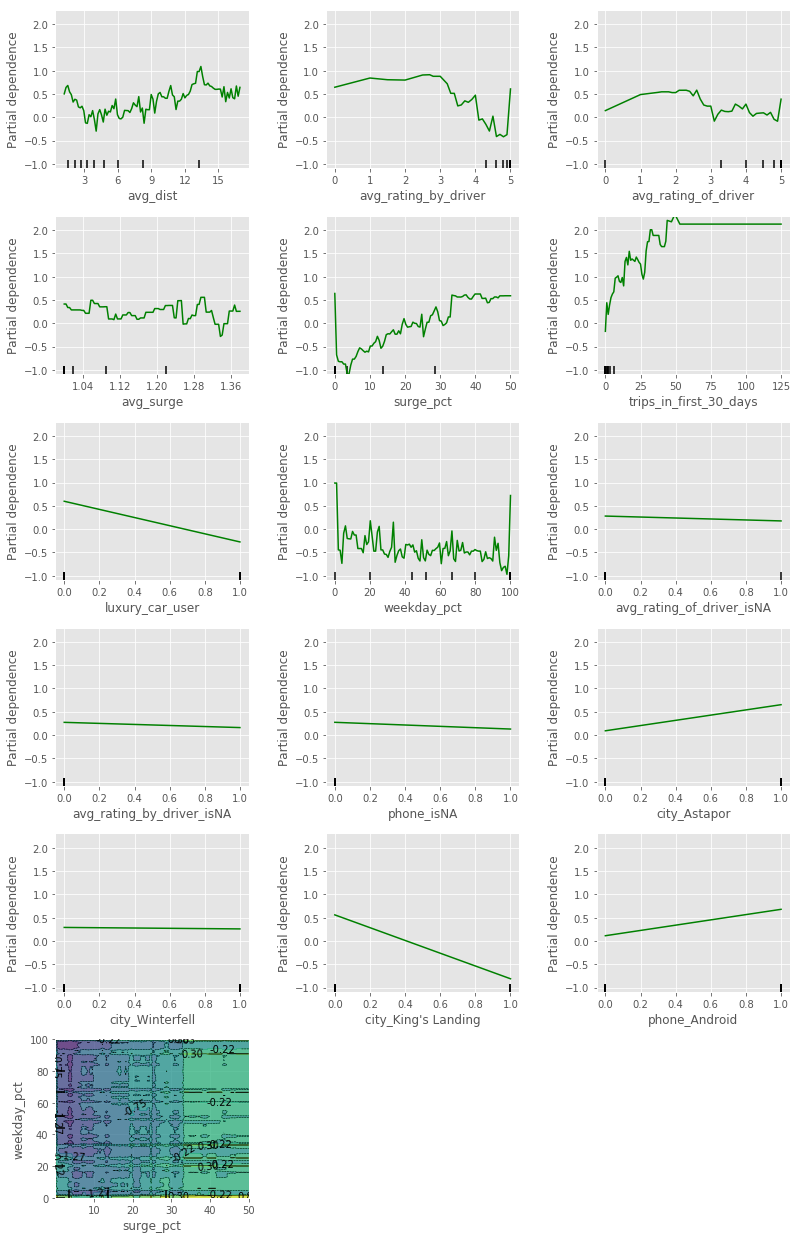

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = gradient_boost_model
fig, axs = plot_partial_dependence(model, 
                                   X = X_train, 
                                   features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,(4,7)],
                                   feature_names=list(X_train.columns),
                                   n_jobs=3, 
                                   grid_resolution=100, 
                                   figsize = (12, 30))
plt.show()